In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))


/tmp/ipykernel_22232/945712042.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import pandas as pd
import os
import argparse
from typing import Any, Callable, Sequence
from pathlib import Path

import jax
import jax.random as jr
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.flatten_util import ravel_pytree
import numpy as np
import matplotlib.pyplot as plt
from flax import linen as nn


from bong.util import run_rebayes_algorithm, gaussian_kl_div, MLP
from bong.src import bbb, blr, bog, bong, experiment_utils
from bong.agents import AGENT_NAMES


In [6]:

rootdir = '/teamspace/studios/this_studio/jobs'
dir = 'linreg-dim10-key0/A:Any-LR:Any-I:10-MC:10-EF:0-R:10-MLP:1'
fname = f"{rootdir}/{dir}/cmds.csv"
df = pd.read_csv(fname)
jobnames = df['jobname']
print(jobnames)
df.head()




0    job-0
1    job-1
2    job-2
Name: jobname, dtype: object


,jobname,command
0,job-0,python /teamspace/studios/this_studio/bong/bon...
1,job-1,python /teamspace/studios/this_studio/bong/bon...
2,job-2,python /teamspace/studios/this_studio/bong/bon...


plotting bong-FC-M10-EF0-Lin0, bong
plotting BLR-FC-M10-I10-LR0_005-EF0-Lin0, BLR
plotting BLR-FC-M10-I10-LR0_01-EF0-Lin0, BLR
plotting BLR-FC-M10-I10-LR0_05-EF0-Lin0, BLR
plotting bog-FC-M10-LR0_005-EF0-Lin0, bog
plotting bog-FC-M10-LR0_01-EF0-Lin0, bog
plotting bog-FC-M10-LR0_05-EF0-Lin0, bog
plotting bbb-FC-M10-I10-LR0_005-EF0-Lin0, bbb
plotting bbb-FC-M10-I10-LR0_01-EF0-Lin0, bbb
plotting bbb-FC-M10-I10-LR0_05-EF0-Lin0, bbb


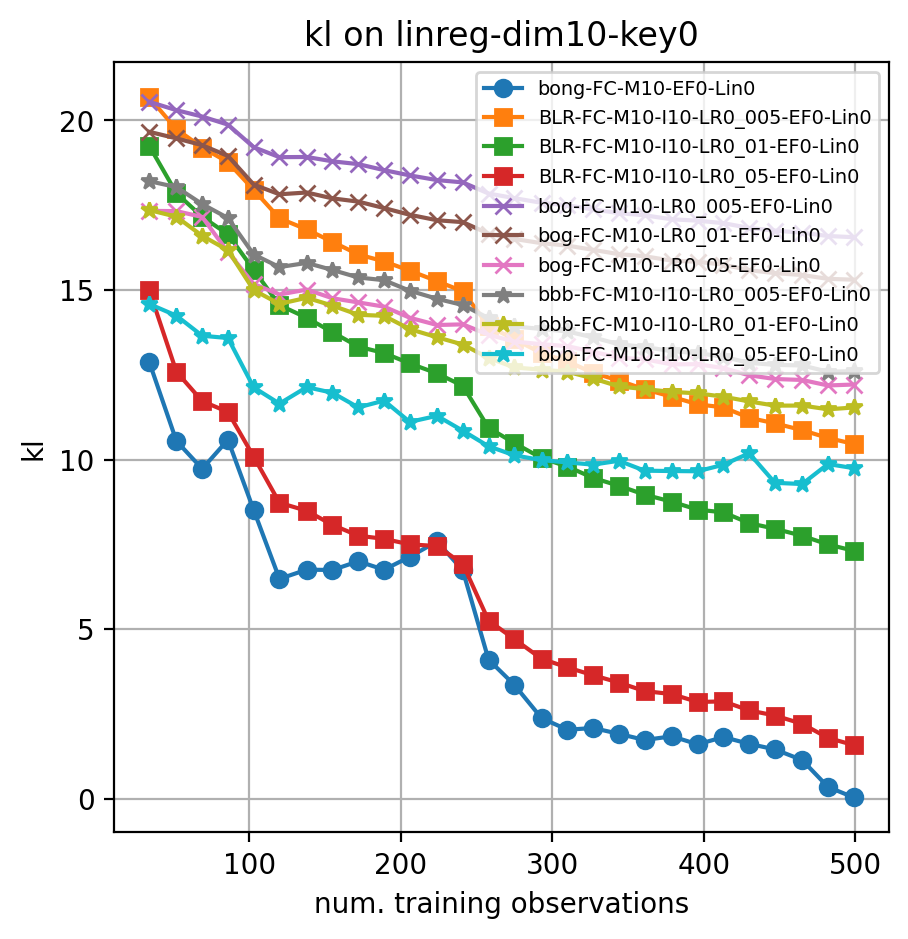

In [90]:
from plot_utils import *
rootdir = '/teamspace/studios/this_studio/jobs'
dir = 'linreg-dim10-key0/A:Any_LR:Any_I:10_MC:10_EF:0_R:10_MLP:1'
fulldir = f'{rootdir}/{dir}'
plot_results_from_files(fulldir,  'kl')

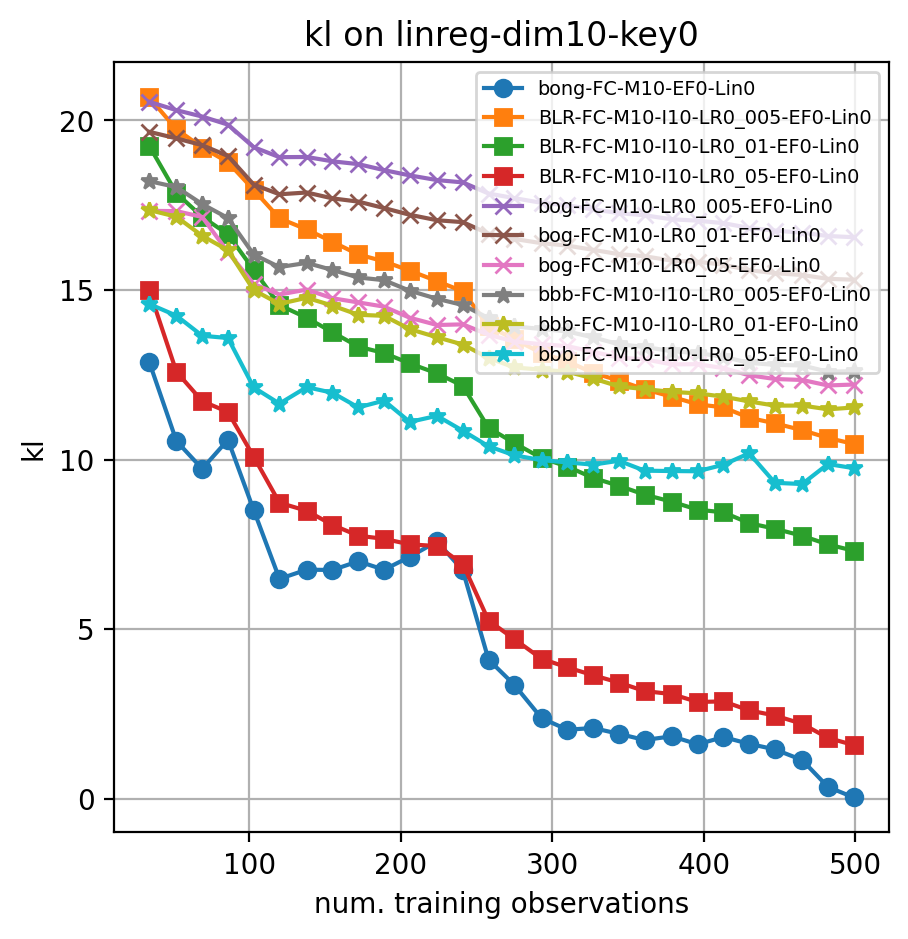

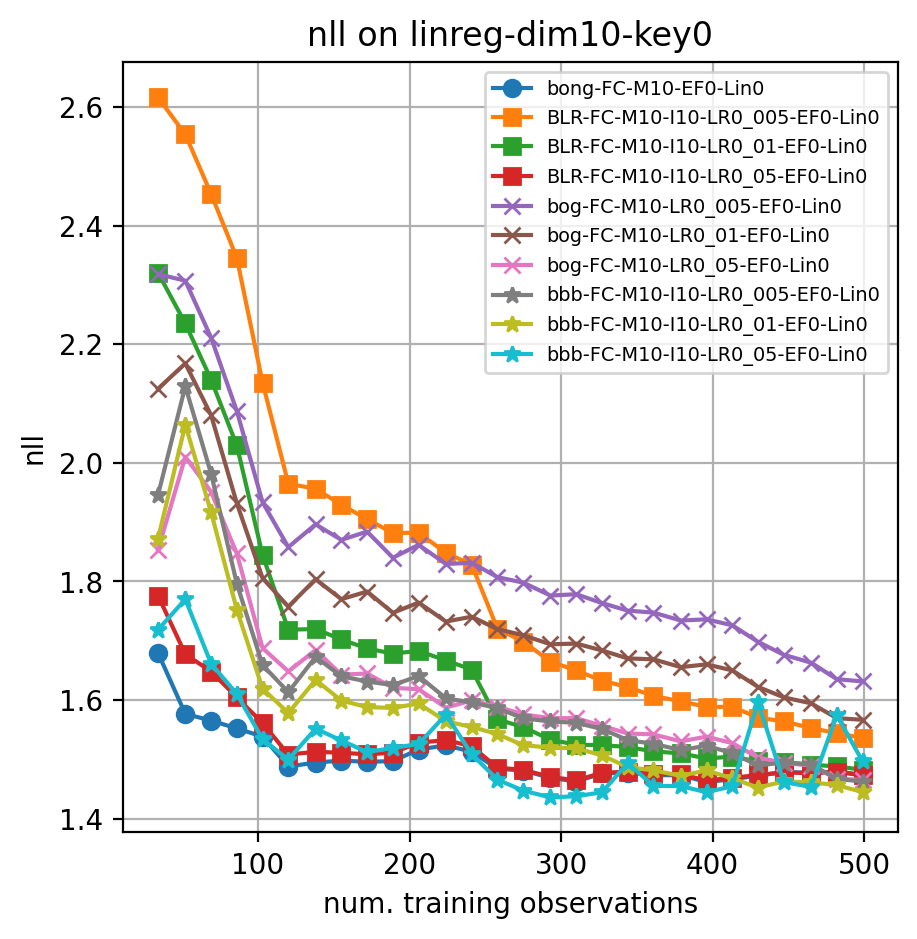

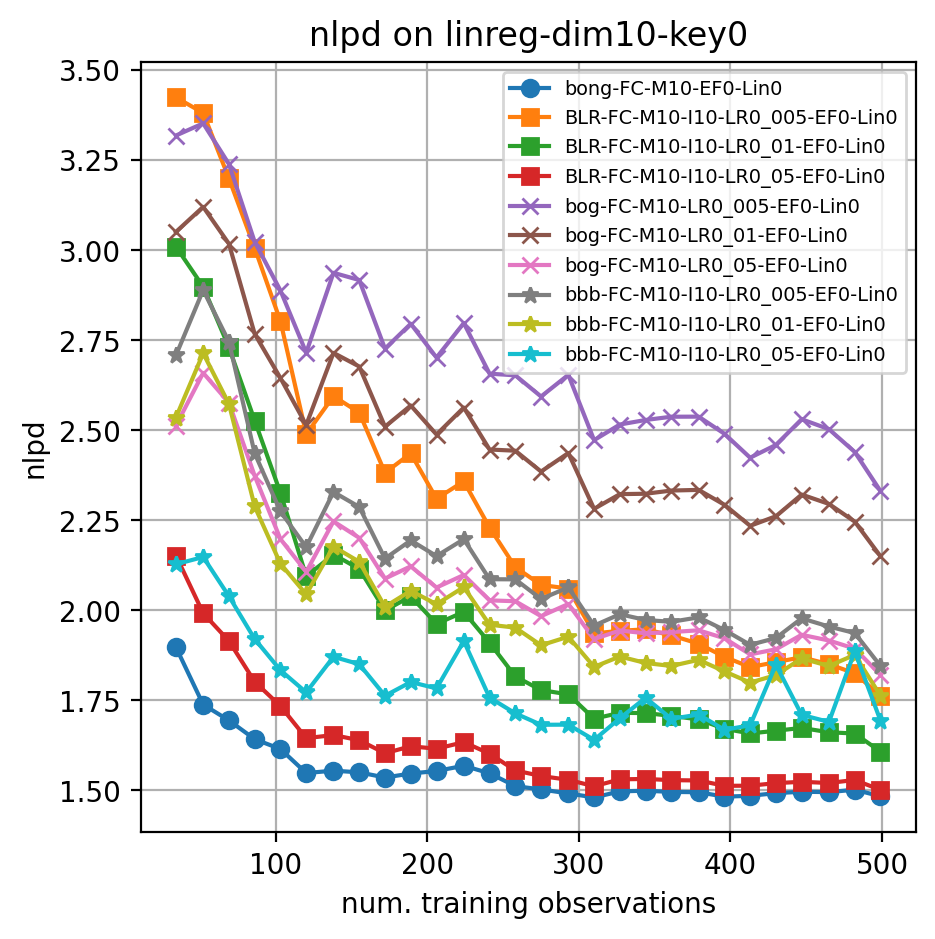

In [58]:

dir = f"/teamspace/studios/this_studio/jobs/linreg10/"
plot_results(dir,  'kl')
plot_results(dir,  'nll')
plot_results(dir,  'nlpd')

In [78]:
parser = argparse.ArgumentParser()

parser.add_argument("--dataset", type=str, default="linreg")
parser.add_argument("--data_dim", type=int, default=10)
parser.add_argument("--data_neurons", type=str, default="20-20-1") # default is nonlinear generator
parser.add_argument("--emission_noise", type=float, default=1.0)
parser.add_argument("--data_key", type=int, default=0)
parser.add_argument("--ntrain", type=int, default=500)
parser.add_argument("--nval", type=int, default=500)
parser.add_argument("--ntest", type=int, default=500)


# Model parameters
parser.add_argument("--agent", type=str, default="bong-fc") #, choices=AGENT_NAMES)
parser.add_argument("--agent_list", type=str, nargs="+", default=["bong-fc", "bbb-fc"]) #, choices=AGENT_NAMES)
parser.add_argument("--agent_key", type=int, default=0)
parser.add_argument("--lr", type=float, default=0.01)
parser.add_argument("--niter", type=int, default=10) 
parser.add_argument("--nsample", type=int, default=10) 
parser.add_argument("--ef", type=int, default=1)
parser.add_argument("--linplugin", type=int, default=0)
parser.add_argument("--model_neurons", type=str, default="10+10+1") # defaut is linear agent 
parser.add_argument("--rank_list", type=int, nargs="+", default=[1, 10])

# results
parser.add_argument("--dir", type=str, default="", help="directory to store results") 
parser.add_argument("--filename", type=str, default="", help="filename prefix")

#args = parser.parse_args()
args = parser.parse_args(args=[])
print(args)

#args_dict = extract_args_dict(args, parser)

Namespace(dataset='linreg', data_dim=10, data_neurons='20-20-1', emission_noise=1.0, data_key=0, ntrain=500, nval=500, ntest=500, agent='bong-fc', agent_list=['bong-fc', 'bbb-fc'], agent_key=0, lr=0.01, niter=10, nsample=10, ef=1, linplugin=0, model_neurons='10+10+1', rank_list=[1, 10], dir='', filename='')


In [ ]:
from mlpreg_data import *


data, init_kwargs, callback, tune_obj_fn = make_mlpreg(args)



WIP******************


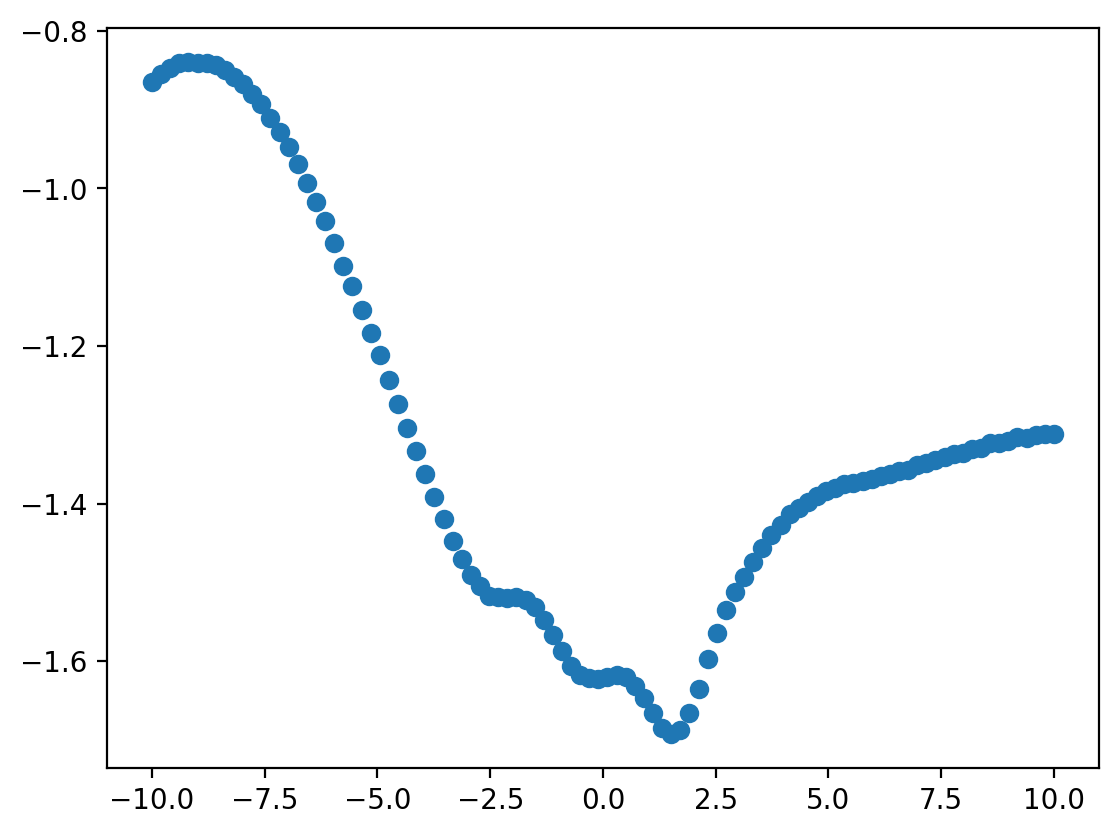

In [ ]:
import linreg_data

keyroot = jr.PRNGKey(0)
key, keyroot = jr.split(keyroot)

N = 100
xs = jnp.linspace(-10, 10, num=N)
X = jnp.reshape(xs, (N,1))
N,d = X.shape
noise_std = 0.001

model = linreg_data.generate_mlp(keyroot, d, nneurons = [10,10,1,])
predictor = model['pred_fn']
Ymean = jax.vmap(predictor)(X)
Y = Ymean + jr.normal(key, (N,1)) * noise_std

ys = Y[:,0]
plt.plot(xs,ys,'o')

In [ ]:
import linreg_run
result_dict = linreg_run.make_results_dict(args)
#result_dict, data, init_kwargs, callback = linreg_run.make_results_dict(args)
#print(result_dict)

Running BLR-FC-M10-I10-LR0_01-EFFalse-LinFalse
KL-Div: 7.0815, NLL: 1.4705,  NLPD: 1.6329, Time: 1.57s


In [ ]:

results_dict = read_job_results(parallel)
print(results_dict.keys())
print(results_dict[jobname])

dict_keys(['bong-0', 'bong-1', 'bong-10', 'bong-11', 'bong-2', 'bong-3', 'bong-4', 'bong-5', 'bong-6', 'bong-7', 'bong-8', 'bong-9'])
   time  step    kl  nll  nlpd
0     0     0   0.0    0     0
1     0     1   2.0   10    10
2     0     2   4.0   20    20
3     0     3   6.0   30    30
4     0     4   8.0   40    40
5     0     5  10.0   50    50
6     0     6  12.0   60    60
7     0     7  14.0   70    70
8     0     8  16.0   80    80
9     0     9  18.0   90    90


In [ ]:
from bong.agents import *


df = make_agent_df(AGENT_DICT)
df.head(n=50)

,constructor,needs_lr,needs_niter,needs_nsamples,linplugin,empirical_fisher,needs_rank,agent
0,<class 'bong.src.bong.fg_bong'>,False,False,True,False,True,False,bong-fc
1,<class 'bong.src.bong.fg_reparam_bong'>,False,False,True,False,True,False,bong-fc-mom
2,<class 'bong.src.bong.dg_bong'>,False,False,True,False,True,False,bong-diag
3,<class 'bong.src.bong.dg_reparam_bong'>,False,False,True,False,True,False,bong-diag-mom
4,<class 'bong.src.bong.dlrg_bong'>,False,False,True,False,True,True,bong-dlr
5,<class 'bong.src.blr.fg_blr'>,True,True,True,False,False,False,blr-fc
6,<class 'bong.src.blr.fg_reparam_blr'>,True,True,True,False,False,False,blr-fc-mom
7,<class 'bong.src.blr.dg_blr'>,True,True,True,False,True,False,blr-diag
8,<class 'bong.src.blr.dg_reparam_blr'>,True,True,True,False,True,False,blr-diag-mom
9,<class 'bong.src.blr.dlrg_blr'>,True,True,True,False,True,True,blr-dlr


In [ ]:

#python  bong/experiments/kpm_linreg.py  --debug True

#python  experiments/kpm_linreg.py  --agents fg-bong --filename "foo_bar"
#python  experiments/kpm_linreg.py  --agents fg-bong fg-l-bong fg-blr fg-bog fg-bbb
#python  experiments/kpm_linreg.py  --agents fg-rep-bong fg-rep-l-bong fg-rep-bog fg-rep-bbb

import argparse

parser = argparse.ArgumentParser()
    
parser.add_argument("--num_examples", type=int, default=500)
parser.add_argument("--param_dim", type=int, default=10)
parser.add_argument("--key", type=int, default=0)
parser.add_argument("--emission_noise", type=float, default=1.0)

# Model parameters
parser.add_argument("--agents", type=str, nargs="+",
                  default=["fg-bong"], choices=AGENT_TYPES)
parser.add_argument("--num_samples", type=int, nargs="+", 
                  default=[10,])

parser.add_argument("--learning_rate", type=float, nargs="+", 
              default=[0.01])
parser.add_argument("--num_iter", type=int, nargs="+", 
              default=[10])
parser.add_argument("--tune_learning_rate", type=bool, default=False)
parser.add_argument("--debug", type=bool, default=False)
parser.add_argument("--filename", type=str, default="")



#https://stackoverflow.com/questions/30656777/how-to-call-module-written-with-argparse-in-ipython-notebook
#args = parser.parse_args()
args = parser.parse_args(args=[])
print(args)

#main(args)#


Namespace(num_examples=500, param_dim=10, key=0, emission_noise=1.0, agents=['fg-bong'], num_samples=[10], learning_rate=[0.01], num_iter=[10], tune_learning_rate=False, debug=False, filename='')


In [ ]:
import os
root = os.getcwd()
#root = "/Users/kpmurphy/github/bong/bong"
curr_path = Path(root, "results")
print(curr_path)

if args.filename == "":
    filename_prefix =  f"linreg_dim{args.param_dim}"
else:
    filename_prefix = args.filename
print("Saving results to", curr_path)
curr_path.mkdir(parents=True, exist_ok=True)

/teamspace/studios/this_studio/results
Saving results to /teamspace/studios/this_studio/results


In [ ]:
data, subkey = make_data(args)
init_kwargs, callback = init(args, data)
prior, post = compute_prior_post(args, data)
 

agent_queue, subkey = make_agent_queue(subkey, args, init_kwargs, None, data['X_tr'], data['Y_tr'])
result_dict = {}
result_dict['laplace'] = (10.0, 1.0, 2.0, 3.0)
result_dict = run_agents(subkey, agent_queue, data, callback, result_dict)






Running fg-bong-M10-I1-LR0...
	KL-Div: 0.0844, Time: 1.51s


In [ ]:
print(result_dict)

{'laplace': (10.0, 1.0, 2.0, 3.0), 'fg-bong-M10-I1-LR0': (0.4651384169701487, Array([22.950815  , 23.836744  , 23.086971  , 22.62736   , 22.643894  ,
       23.653706  , 23.81697   , 23.206947  , 22.475372  , 21.49679   ,
       21.558895  , 22.801449  , 18.805405  , 15.997734  , 14.256347  ,
       14.280935  , 14.002972  , 13.844494  , 13.763961  , 13.119299  ,
       13.120931  , 13.138289  , 13.091949  , 12.731443  , 11.946014  ,
       12.070639  , 12.2719755 , 12.154854  , 11.480072  , 11.429003  ,
       11.424678  , 11.174073  , 10.927644  , 11.577087  , 11.491255  ,
       12.533128  , 12.389325  , 12.312702  , 12.25417   , 12.438559  ,
       12.502064  , 12.477814  , 12.456735  , 12.404019  , 12.179851  ,
       11.335275  , 10.502107  , 10.637063  , 10.50477   , 10.513651  ,
       10.346122  , 10.300872  , 10.222781  ,  9.984198  , 10.002081  ,
        9.934994  ,  9.873008  ,  9.682464  ,  9.132798  ,  9.035919  ,
        8.946268  ,  9.195013  ,  9.117326  ,  9.591936  ,

In [ ]:
fname = "/Users/kpmurphy/github/bong/bong/results/baz_parsed.csv"
df = pd.read_csv(fname)
df.tail()



,prefix,M,I,LR,name,step,kl,nll,nlpd,time
13496,fg-bog,10,10,0.05,fg-bog-M10-I10-LR0_05,495,NaN,NaN,NaN,1.861322
13497,fg-bog,10,10,0.05,fg-bog-M10-I10-LR0_05,496,NaN,NaN,NaN,1.861322
13498,fg-bog,10,10,0.05,fg-bog-M10-I10-LR0_05,497,NaN,NaN,NaN,1.861322
13499,fg-bog,10,10,0.05,fg-bog-M10-I10-LR0_05,498,NaN,NaN,NaN,1.861322
13500,fg-bog,10,10,0.05,fg-bog-M10-I10-LR0_05,499,NaN,NaN,NaN,1.861322


In [ ]:
def make_marker(name):
    #https://matplotlib.org/stable/api/markers_api.html
    markers = {'bong': 'o', 'blr': 's', 'bog': 'x', 'bbb': '*'}
    if "bong" in name:
        return markers['bong']
    elif "blr" in name:
        return markers['blr']
    elif "bog" in name:
        return markers['bog']
    elif "bbb" in name:
        return markers['bbb']
    else:
        return 'P;'

500


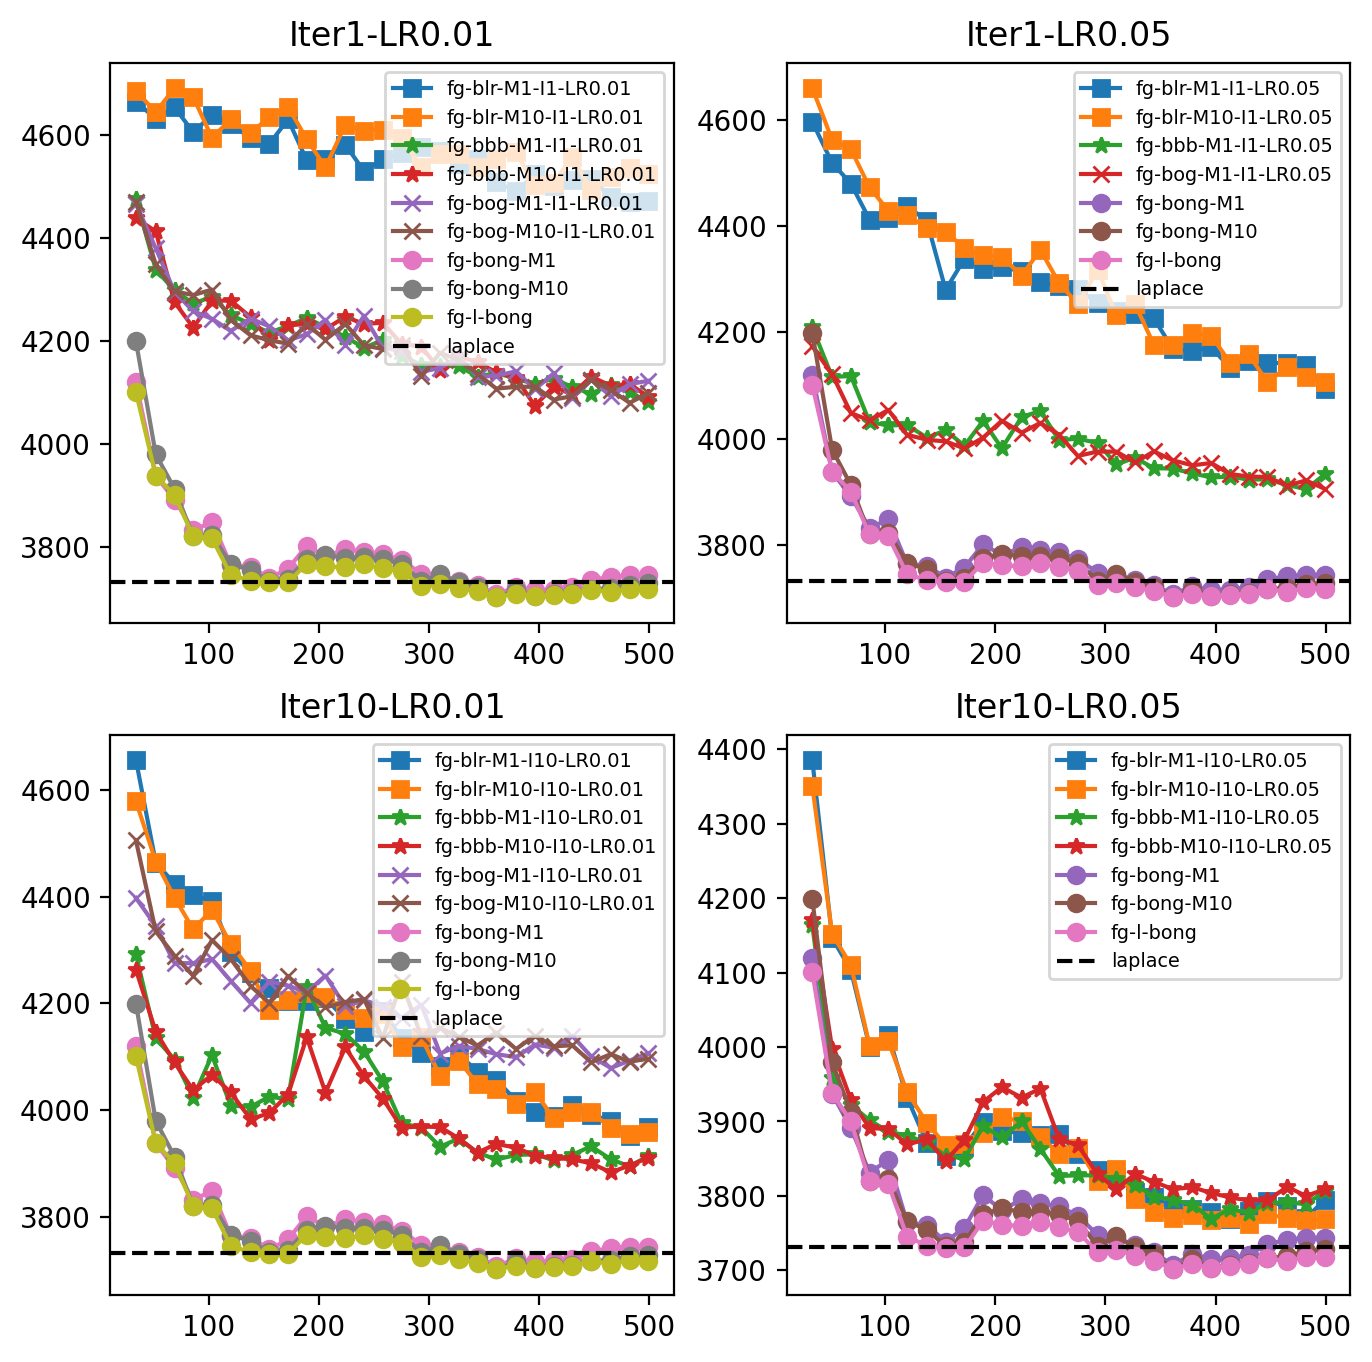

In [ ]:

niters = df['I'].unique()
niters = niters[niters != 0]

lrs = df['LR'].unique()
lrs = lrs[lrs != 0]

mcs = df['M'].unique()
mcs = mcs[mcs != 0]

agents = df['prefix'].unique()
agents = agents[ agents != "laplace" ]
agents = agents[ agents != "fg-bong" ]
agents = agents[ agents != "fg-l-bong" ]

fs = 'x-small'
loc = 'upper right' #'lower left'

df2 = df[ df['prefix']=='fg-l-bong']
kl = df2['kl'].to_numpy()
T = len(kl)
print(T)

# extract subset of points for plotting to avoid cluttered markers
#ndx = jnp.array(range(0, T, 10)) # decimation of points 
ndx = round(jnp.linspace(0, T-1, num=min(T,30)))
# skip first 2 time steps, since it messes up the vertical scale
ndx = ndx[2:]

fig, axs = plt.subplots(len(niters), len(lrs), figsize=(8, 8))
for i, niter in enumerate(niters):
    for j, lr in enumerate(lrs):
        ax = axs[i,j]
        df2 = df[ (df['I']==niter) & (df['LR']==lr) ]
        for agent in agents:
            df3 = df2[df2['prefix']==agent]
            for mc in mcs:
                df4 = df3[ (df3['M']==mc) ]
                name = f'{agent}-M{mc}-I{niter}-LR{lr}'
                #print(name)
                steps = df4['step'].to_numpy()
                kl = df4['kl'].to_numpy()
                if np.any(np.isnan(kl)):
                    continue
                else:
                  ax.plot(steps[ndx], kl[ndx], label=name, marker=make_marker(agent))

        if 'fg-bong' in df['prefix'].unique():
            agent = 'fg-bong' # not indexed by I,LR
            df2 = df[ (df['prefix']==agent) ]
            for mc in mcs:
                df3 = df2[ (df2['M']==mc) ]
                name = f'{agent}-M{mc}'
                steps = df3['step'].to_numpy()
                kl = df3['kl'].to_numpy()
                ax.plot(steps[ndx], kl[ndx], label=name, marker=make_marker(agent))
        
        if 'fg-l-bong' in df['prefix'].unique():
            agent = 'fg-l-bong' # not indexed by I,LR,M
            df2 = df[df['prefix']==agent]
            name = f'{agent}'
            steps = df2['step'].to_numpy()
            kl = df2['kl'].to_numpy()
            ax.plot(steps[ndx], kl[ndx], label=name, marker=make_marker(agent))
        
        if 'laplace' in df['prefix'].unique():
            df2 = df[ (df['prefix']=='laplace') ]
            kldiv = df2['kl'].to_numpy()[0]
            ax.axhline(kldiv, color="black", linestyle="--", label='laplace')

        ax.legend(loc=loc, prop={'size': fs})
        ax.set_title(f'Iter{niter}-LR{lr}')

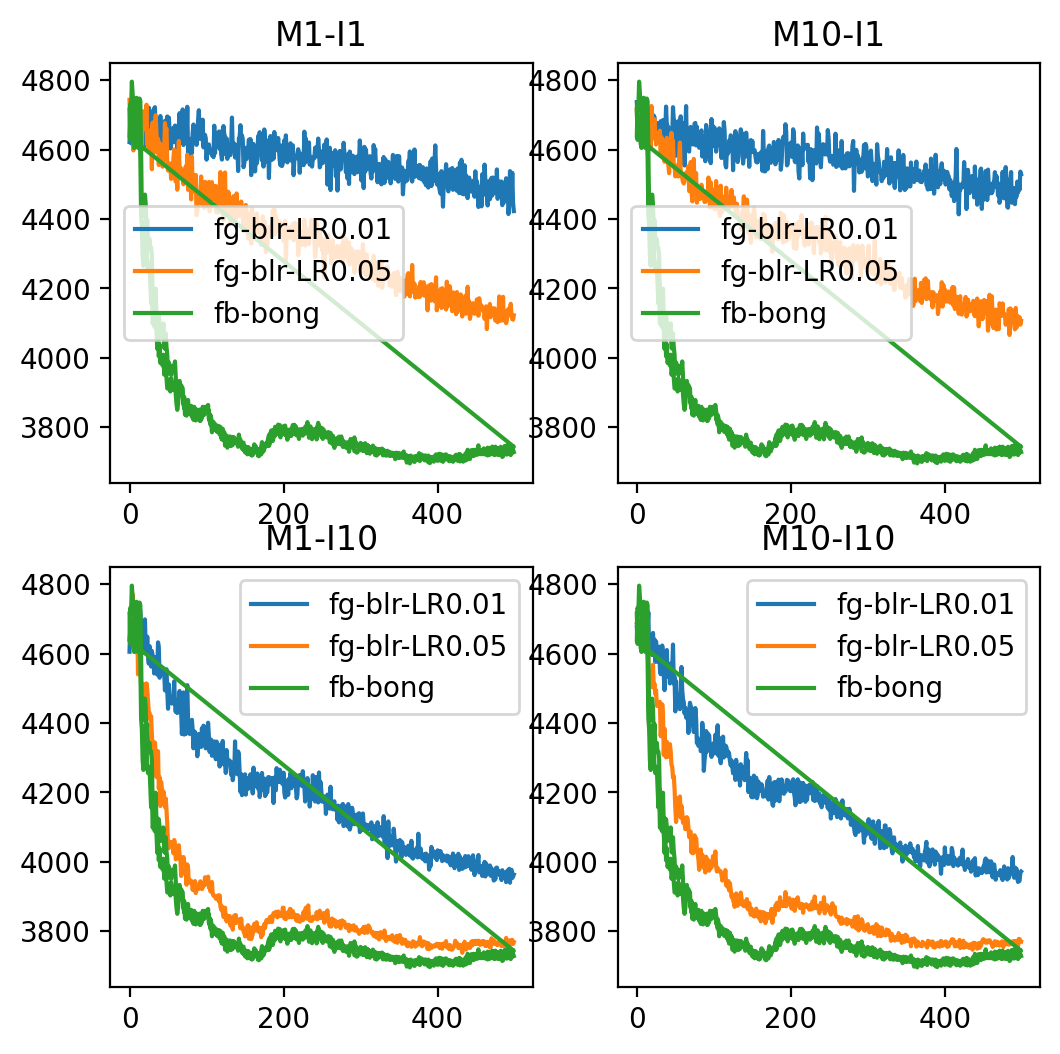

In [ ]:


niters = df['I'].unique()
niters = niters[niters != 0]

mcs = df['M'].unique()
mcs = mcs[mcs != 0]

lrs = df['LR'].unique()
lrs = lrs[lrs != 0]


fig, axs = plt.subplots(len(niters), len(mcs), figsize=(6, 6))
for i, niter in enumerate(niters):
    for m, mc in enumerate(mcs):
        ax = axs[i,m]
        dfsub = df[ (df['I']==niter) & (df['M']==mc) ]
        for agent in agents:
            for lr in lrs:
                dfsub2 = dfsub[ (dfsub['prefix']==agent) & (dfsub['LR']==lr) ]
                ax.plot(dfsub2['step'], dfsub2['kl'], label=f'{agent}-LR{lr}')

        if 'fg-bong' in df['prefix'].unique():
            dfsub2 = df[ (df['prefix']=='fg-bong') ]
            ax.plot(dfsub2['step'], dfsub2['kl'], label=f'fb-bong')

        if 'laplace' in df['prefix'].unique():
            dfsub2 = df[ (df['prefix']=='laplace') ]
            #ax.plot(dfsub2['step'], dfsub2['kl'], label=f'fb-bong')

        ax.legend()
        ax.set_title(f'M{mc}-I{niter}')


In [ ]:
niter,mc=10,10
dfsub = df[ (df['I']==niter) & (df['M']==mc) ]
print(dfsub)

      prefix   M   I    LR                   name  step         kl       nll  \
3501  fg-blr  10  10  0.01  fg-blr-M10-I10-LR0_01     0  4676.8800  0.829247   
3502  fg-blr  10  10  0.01  fg-blr-M10-I10-LR0_01     1  4638.6110  0.830271   
3503  fg-blr  10  10  0.01  fg-blr-M10-I10-LR0_01     2  4711.2515  0.831777   
3504  fg-blr  10  10  0.01  fg-blr-M10-I10-LR0_01     3  4733.3030  0.832249   
3505  fg-blr  10  10  0.01  fg-blr-M10-I10-LR0_01     4  4655.0474  0.833845   
...      ...  ..  ..   ...                    ...   ...        ...       ...   
4996  fg-blr  10  10  0.05  fg-blr-M10-I10-LR0_05   495  3755.1707  0.671016   
4997  fg-blr  10  10  0.05  fg-blr-M10-I10-LR0_05   496  3777.9292  0.669536   
4998  fg-blr  10  10  0.05  fg-blr-M10-I10-LR0_05   497  3777.8990  0.669020   
4999  fg-blr  10  10  0.05  fg-blr-M10-I10-LR0_05   498  3770.8887  0.668353   
5000  fg-blr  10  10  0.05  fg-blr-M10-I10-LR0_05   499  3770.4026  0.668435   

          nlpd      time  
3501  1.0114